<a href="https://colab.research.google.com/github/fedhere/MLTSA22_ITyagin/blob/main/HW3/HW3_IlyaTyagin_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color=red> FBB: check the comments below</font>


In [ ]:
import pandas as pd
import numpy as np
import pylab as pl
import glob
%pylab inline

from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
import json
import os


In [ ]:
pip install statsmodels==0.11.1

In [ ]:
pip install pandas==1.1.3

     |████████████████████████████████| 9.5 MB 13.8 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [ ]:
import statsmodels

In [ ]:
statsmodels.__version__

'0.11.1'

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA22_FBianco/master/fbb.mplstyle")

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


loading HW2 cause that is where the data is, even if this is HW3

In [ ]:
cd /content/gdrive/MyDrive/Classes/22S-PHYS-667/HW2

/content/gdrive/MyDrive/Classes/22S-PHYS-667/HW2


# Part 1: data ingestion, exploration, preparation 
#...continuing on from HW2... 
you can start with the HW2 notebook you created or my solution which is in https://github.com/fedhere/MLTSA22_FBianco/tree/main/HW2


In [ ]:
#files paths are stored in the allfiles variable sorted alphabetically...
allfiles = sorted(glob.glob("Data/Stocks/*.txt"))[:10]

# merged dataframes are stored into a single dataframe called tss. Inspect it as discussed

tss = (
    pd.read_csv(allfiles[0])
      .set_index('Date')[['Close']]
      .rename(
          columns={'Close': allfiles[0].split('/')[-1][:-4]}
      )
    )

for fname in tqdm(allfiles[1:]):
  tss = tss.merge(
      (
        pd.read_csv(fname)
          .set_index('Date')[['Close']]
          .rename(
              columns={'Close': fname.split('/')[-1][:-4]}
              )
          ), 
          on='Date'
  )

100%|██████████| 9/9 [00:00<00:00, 76.30it/s]


## testing for stationarity (you did it in HW2 but it will be useful have it here under your eyes)
test if each of these time series is stationary using the AD fuller test using ```statsmodels.api.tsa.stattools.adfuller()```

```for f in tss.columns:
    sm.tsa.stattools.adfuller(tss[c])```

Have the code automatically print a statement about wheather the ts is stationary for each ts (for example in a for loop).

In [ ]:
threshold = 0.05
print ("Stationarity results from the AD Fuller test at a p-value of 0.05")
for c in tss.columns:
    print(c, "is stationary:", sm.tsa.stattools.adfuller(tss[c])[1] < threshold)

Stationarity results from the AD Fuller test at a p-value of 0.05
a.us is stationary: False
aa.us is stationary: False
aaap.us is stationary: False
aaba.us is stationary: False
aac.us is stationary: False
aal.us is stationary: False
aamc.us is stationary: False
aame.us is stationary: True
aan.us is stationary: False
aaoi.us is stationary: False


# 1. Question: why did I set the threshold to 0.05? what does 0.05 mean? 

0.05 represents the 2$\sigma$ statistical significance level (we are 95% sure that the model is stationary).

# 2. Task: measure autocorrelation

plot the time series and its autocorrelation and partial autocorrelation function in blue if it is not stationary, in red if it is stationary

As a reminder, the plotting function for the autocorrelation and partial autocorelation functions works as follows

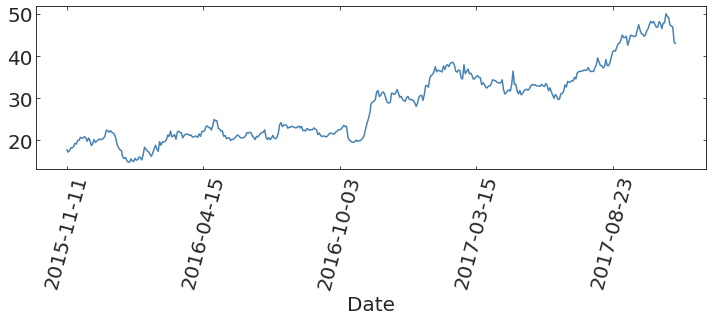

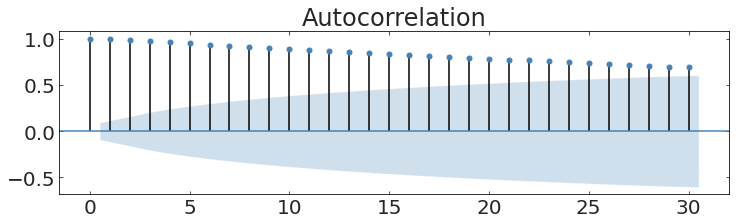

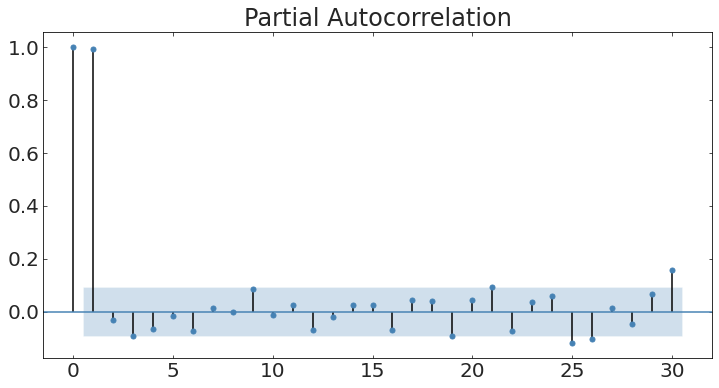

In [ ]:
tss["aa.us"].plot(rot=75, figsize=(12,3));
ax = pl.figure(figsize=(12,3)).add_subplot(111)
sm.graphics.tsa.plot_acf(tss["aa.us"], lags=30, ax=ax)
ax = pl.figure(figsize=(12,6)).add_subplot(111)
fig = sm.graphics.tsa.plot_pacf(tss["aa.us"], lags=30, ax=ax);

# 3. Question: pick one of the time series (of your choice) and tell me which lags are expected to be significant in the model based on the ACF and PACF plots you made

Fig 4: Autocorrelation and partial autocorrelation plots. We can see that significant lags are 25th and 30th.

<font color=red> FBB:  describe the design of the plot - what is the shaded area, and in this case, where statsmodels does not even put x and y labels, what do the x and y values mean!</font>

# 4. Task: training and testing split
To set up a training and test set for this, remove the last two months of data (60 days) and use it as a test set. Were your predictions good enough to make you rich? Predict 100 days forward of the training set

you do not have to overthink it and create differnt variables, you can simply select data without the last 2 month when you pass the data to the fit function. Here, make a plot of the first time series plotting in blue the training data and in orange the test data

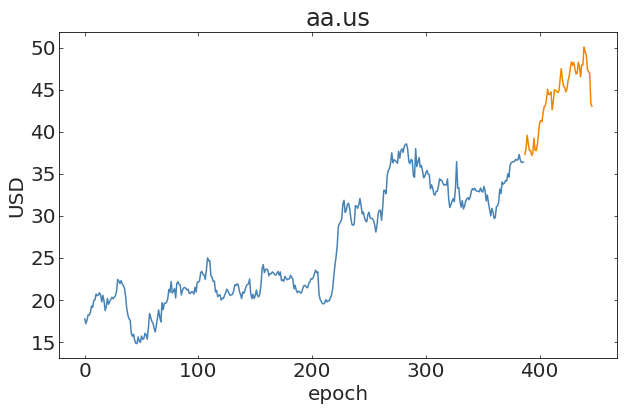

In [ ]:
pl.plot(np.arange(tss.shape[0] - 60), tss.loc[:,"aa.us"][:-60])
pl.plot(np.arange(tss.shape[0] - 60, tss.shape[0]), tss.loc[:,"aa.us"][-60:]);
pl.title("aa.us")
pl.xlabel("epoch")
pl.ylabel("USD");

<font color=red> FBB:  all plots should have captions! whatr did you plot? what are the colors?</font>

# Part 2: Model and Forecast
Here we are doing sock price analysis. The most likely reason is that we want to make $$$ - so we want to forecast the future. 


To fit the model to the data use ```statsmodels.api.tsa.ARMA```

You can inspect the function call as ```statsmodels.api.tsa.ARMA?```
The statsmodels models are generally fit into 2 phases: generating the model ```sm.tsa.ARMA(data, parameters)```, and then fitting it ```sm.tsa.ARMA(data, parameters).fit()```. 

To look at the model result, including the AIC,  look at the model summary ```mod.summary()``` What are the best fit parameters based on this printed summary and thewir uncertainties? What is the value of the AIC(Aikiki Information Criterion)

See https://github.com/fedhere/MLTSA22_FBianco/CodeExamples/ARMA/testingARMA_ARIMA.ipynb



# 5. Task: Fit one of the stationary time series with ARMA
a. Fit the model for a variety of parameters. You can run a nested loop to iterate over a range of p and q parameters. 

b. At each loop step record the AIC score for each fit. 

c. Find the best parameters to fit this time series with the AIC minimization criterion. For each model, after you fit it to the data, you can get the value of the AIC as ```model.aic```

In [ ]:
#example of model output
mod = sm.tsa.ARMA(tss[['aame.us']], (1,1)).fit()

#(tss[c], (3,1), dates=tss["Date"], ).fit()
#mod.plot_predict(dynamic=True, plot_insample=False)
mod.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                aame.us   No. Observations:                  447
Model:                     ARMA(1, 1)   Log Likelihood                 301.057
Method:                       css-mle   S.D. of innovations              0.123
Date:                Wed, 02 Mar 2022   AIC                           -594.115
Time:                        04:16:44   BIC                           -577.705
Sample:                             0   HQIC                          -587.645
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.9275      0.204     19.247      0.000       3.528       4.327
ar.L1.aame.us     0.9811      0.010    100.057      0.000       0.962       1.000
ma.L1.aame.us    -0.2706      0.049     -5.576      0.000      -0.366      -0.175
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0192           +0.0000j            1.0192            0.0000
MA.1            3.6958           +0.0000j            3.6958            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
mod.aic

-594.1149218798437

In [ ]:
#example of how you could set a for loop to save the AIC values for each model
aics = dict()
#aics = np.zeros((5,5))
for timeseries in ["aa.us"]:
  aics[timeseries] = np.zeros((5,5))
  for p in tqdm(range(1, 6)):
    for q in range(1, 6):
      mod = sm.tsa.ARMA(
          tss[[timeseries]][:-30], 
          (p,q)
          ).fit()
      aics[timeseries][p-1][q-1] = mod.aic
print("best parameters: ", np.where(aics["aa.us"] == np.nanmin(aics["aa.us"])))

100%|██████████| 5/5 [00:46<00:00,  9.31s/it]

best parameters:  (array([3]), array([4]))


In [ ]:
mod = sm.tsa.ARMA(
    tss[[timeseries]][:-30], 
    (3,4)
    ).fit()

<font color=red> FBB:  you did a lot of nice things, but ... you did not tell me about anything you did! think about these homeworks as a medium post, or towardsdatascience post. Describe what you do and why</font>

## 6. Task: predict the in-set (training) and the future alues

you can use ```mod.plot_predict()``` to generate and visualize the prediction at once

In [ ]:
# the lenght of the data
N = tss[['aa.us']].shape[0]

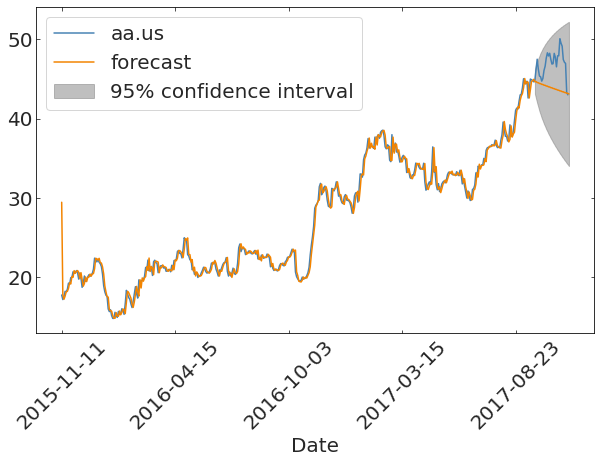

In [ ]:
ax = tss[['aa.us']].plot()

mod.plot_predict(end=N, plot_insample=False, ax=ax);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

<font color=red> FBB:  No Caption??!?</font>

# 7. Question: Did you make money??
No! The prediction was way too pessimistic and did not reflect the real trend.

# 8. Question: what are the coefficients of the best fit model? what do they mean? 


coefficients p and q:


p: lag order: number of lag observations in the AM model; AM(p)

q: order of the moving average: the size of the moving average window;

In [ ]:
coefficients p and q

#  9. Task: choose 2 non stationary time series in the set that are not correlated and repeat Tasks 5 amd 6 with the ARIMA model

choose integration 1 to start ...

In [ ]:
tss.corr()

,a.us,aa.us,aaap.us,aaba.us,aac.us,aal.us,aamc.us,aame.us,aan.us,aaoi.us
a.us,1.000000,0.902139,0.800310,0.973457,-0.721867,0.621041,0.897263,-0.699609,0.905395,0.851239
aa.us,0.902139,1.000000,0.776600,0.904210,-0.791137,0.713229,0.893952,-0.606774,0.873520,0.766459
aaap.us,0.800310,0.776600,1.000000,0.872134,-0.423021,0.451520,0.621329,-0.573976,0.696179,0.560427
aaba.us,0.973457,0.904210,0.872134,1.000000,-0.670578,0.612989,0.849972,-0.709023,0.903785,0.809059
aac.us,-0.721867,-0.791137,-0.423021,-0.670578,1.000000,-0.785248,-0.868936,0.510986,-0.765267,-0.780147
aal.us,0.621041,0.713229,0.451520,0.612989,-0.785248,1.000000,0.780517,-0.219258,0.756808,0.746505
aamc.us,0.897263,0.893952,0.621329,0.849972,-0.868936,0.780517,1.000000,-0.544740,0.881631,0.904166
aame.us,-0.699609,-0.606774,-0.573976,-0.709023,0.510986,-0.219258,-0.544740,1.000000,-0.585002,-0.496371
aan.us,0.905395,0.873520,0.696179,0.903785,-0.765267,0.756808,0.881631,-0.585002,1.000000,0.860847
aaoi.us,0.851239,0.766459,0.560427,0.809059,-0.780147,0.746505,0.904166,-0.496371,0.860847,1.000000


In [ ]:
#example of how you could set a for loop to save the AIC values for each model
aics = dict()
#aics = np.zeros((5,5))
for timeseries in ["aaap.us", "aal.us"]:
  aics[timeseries] = np.zeros((5,5))
  for p in tqdm(range(1, 6)):
    for q in range(1, 6):
      mod = statsmodels.tsa.arima.model.ARIMA(
          tss[[timeseries]][:-30], 
          order=(p,1,q),
          enforce_stationarity=False,
          ).fit()
      aics[timeseries][p-1][q-1] = mod.aic
  print(f"best parameters for {timeseries}: ", np.where(aics[timeseries] == np.nanmin(aics[timeseries])))

100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


best parameters for aaap.us:  (array([2]), array([4]))


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]

best parameters for aal.us:  (array([1]), array([4]))


In [ ]:
mod_aaap = sm.tsa.ARIMA(
  tss[['aaap.us']][:-30], 
  order=(2,1,4),
  #enforce_stationarity=False,
  ).fit()

mod_aal = sm.tsa.ARIMA(
  tss[['aal.us']][:-30], 
  order=(1,1,4),
  #enforce_stationarity=False,
  ).fit()

#10. Question: Did you get rich?

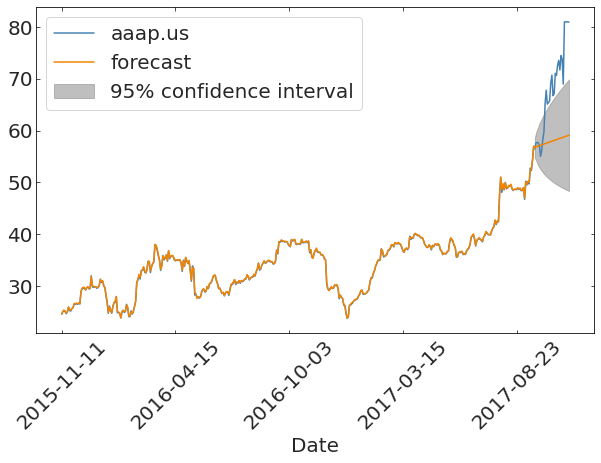

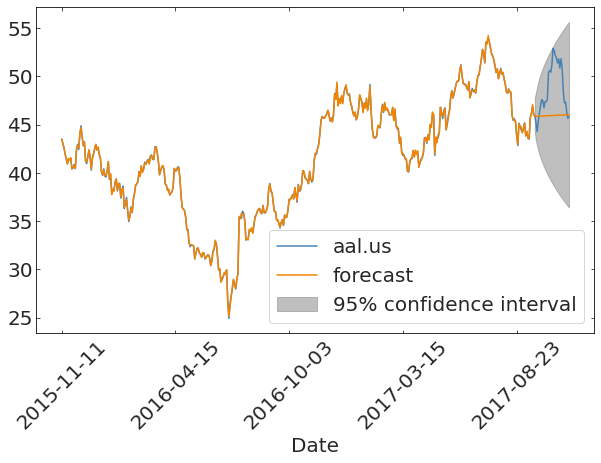

In [ ]:
# the lenght of the data
N = tss[['aaap.us']].shape[0]

ax = tss[['aaap.us']].plot()

mod_aaap.plot_predict(end=N, plot_insample=False, ax=ax);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

N = tss[['aal.us']].shape[0]

ax = tss[['aal.us']].plot()

mod_aal.plot_predict(end=N, plot_insample=False, ax=ax);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

No, we didn't get rich! in both cases forecasts show significantly smaller values than actual trends.

<font color=red> FBB: are you sure? in the first case the trend is up, so you likely buy, and the stock gets much more expensive then when you bought. So you made money! </font>

# 11 Task: Redo the fit to one of the non-stsationary lightcurves with a different order of integration and compare the results. What do the coefficients tell you?

In [ ]:
mod_aal_2nd_order = sm.tsa.ARIMA(
  tss[['aal.us']][:-30], 
  order=(1,2,4),
  #enforce_stationarity=False,
  ).fit()

In [ ]:
mod_aal_2nd_order.aic

1120.9938644396423

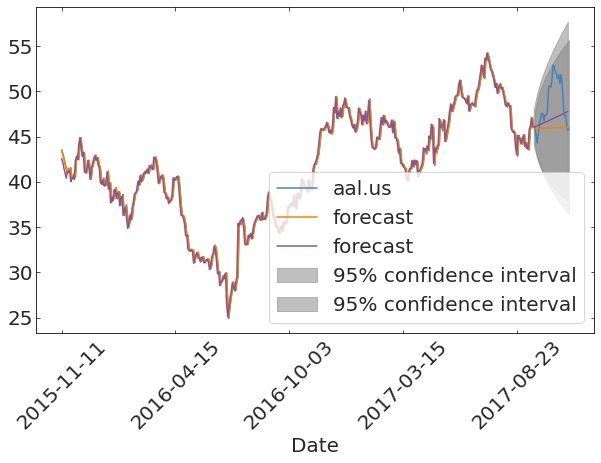

In [ ]:
N = tss[['aal.us']].shape[0]

ax = tss[['aal.us']].plot()

mod_aal.plot_predict(end=N, plot_insample=False, ax=ax);
mod_aal_2nd_order.plot_predict(end=N, plot_insample=False, ax=ax);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

In [ ]:
mod_aal.aic, mod_aal_2nd_order.aic

(1117.1305623148216, 1120.9938644396423)

AIC coefficients take into account both fit quality and parsimony. If we compare these numbers, we'll notice that adding 2nd order of integration is not worth it from the AIC prospective, but the result look better on the plot.

<font color=red> FBB:  very good analysks. still missing plot captions</font>